In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms.v2 as v2

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
from itertools import chain, pairwise
import random
from tqdm import tqdm
import sys

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
)

sys.path.append('./src')
from src.data import MultiSet, ImageTransforms, ProfileTransform, PairAugmentation
from src.profile_encoder import ProfileTransformer
from src.image_encoder import ImageEncoder
from src.model import MultiModel
from src.coordination import DistanceLoss, CLIPLoss, RankLoss
from src.zeroshot import ANNZeroShot

from lightning import Trainer
import logging

# from torch.utils.tensorboard import SummaryWriter
# from accelerate import Accelerator
# from accelerate.utils import GradientAccumulationPlugin

import scienceplots
plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

# %matplotlib widget

import timm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pacmap



ModuleNotFoundError: No module named 'lightning'

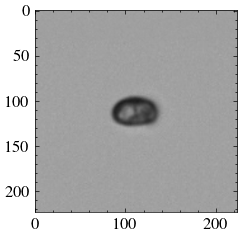

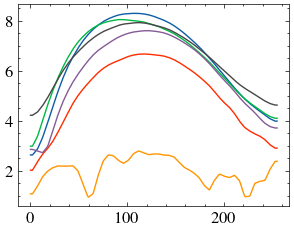

tensor(0.9406)

In [4]:
id = random.randint(0, len(test_set)-1)
data = test_set[id]

plt.imshow(data['image'].permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)
plt.show()

plt.plot(data['profile'])
plt.show()

data['profile'].min()

In [31]:
annot = pd.read_csv(data_path / 'train.csv')
annot

,Unnamed: 0,ID,class_name
0,581,582,Aphanizomenon_flosaquae
1,643,644,Aphanizomenon_flosaquae
2,679,680,Aphanizomenon_flosaquae
3,492,493,Aphanizomenon_flosaquae
4,744,745,Aphanizomenon_flosaquae
...,...,...,...
6139,19317,19318,Tetraselmis_sp
6140,19284,19285,Tetraselmis_sp
6141,19325,19326,Tetraselmis_sp
6142,19509,19510,Tetraselmis_sp


In [66]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train, test in kfold.split(annot, annot.class_name):
    print(annot.iloc[test])


      Unnamed: 0     ID               class_name
21           793    794  Aphanizomenon_flosaquae
26           794    795  Aphanizomenon_flosaquae
29           184    185  Aphanizomenon_flosaquae
37           208    209  Aphanizomenon_flosaquae
38           520    521  Aphanizomenon_flosaquae
...          ...    ...                      ...
6106       19904  19905           Tetraselmis_sp
6109       19592  19593           Tetraselmis_sp
6111       20026  20027           Tetraselmis_sp
6116       19343  19344           Tetraselmis_sp
6137       19604  19605           Tetraselmis_sp

[1229 rows x 3 columns]
      Unnamed: 0     ID               class_name
1            643    644  Aphanizomenon_flosaquae
3            492    493  Aphanizomenon_flosaquae
8            832    833  Aphanizomenon_flosaquae
15           486    487  Aphanizomenon_flosaquae
19           425    426  Aphanizomenon_flosaquae
...          ...    ...                      ...
6129       19578  19579           Tetraselmi

In [17]:
annotation_id = 'fold1'
max_len = 256

data_path = Path('./data/FASTVISION-plus') / annotation_id

image_transforms = ImageTransforms()
signal_transforms = ProfileTransform(max_len=max_len)
pair_augmentation = PairAugmentation()

train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                   image_transforms=image_transforms,
                   profile_transform=signal_transforms,
                   pair_augmentation=pair_augmentation)

test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                    image_transforms=image_transforms,
                    profile_transform=signal_transforms,
                    pair_augmentation=None)


In [17]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

names = (
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_clip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_siglip_FASTVISION-plus',
)

embeddings = {name: {} for name in names}

for name in names: 
    for i in range(1, 6):
        path = Path(f'logs/{name}_fold{i}/version_0/checkpoints')
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)
        max_len = 256
        data_path = Path(f'./data/FASTVISION-plus/fold{i}')

        image_transforms = ImageTransforms()
        signal_transforms = ProfileTransform(max_len=max_len)
        pair_augmentation = PairAugmentation()

        train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                           image_transforms=image_transforms,
                           profile_transform=signal_transforms,
                           pair_augmentation=pair_augmentation)

        test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms,
                            pair_augmentation=None)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': model.name_to_id(label)}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
    
        train_loader = DataLoader(dataset=train_set, batch_size=128, 
                                  num_workers=8, collate_fn=multi_collate)
    
        test_loader = DataLoader(dataset=test_set, batch_size=128, 
                                 num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        train = trainer.predict(model, train_loader)
        image_train, profile_train, label_train = zip(*(sample.values() for sample in train))
    
        test = trainer.predict(model, test_loader)
        image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

        I_train = torch.cat(image_train).numpy()
        P_train  = torch.cat(profile_train).numpy()
        L_train = torch.cat(label_train).numpy()
    
        I_test = torch.cat(image_test).numpy()
        P_test  = torch.cat(profile_test).numpy()
        L_test = torch.cat(label_test).numpy()

        embeddings[name][i] = {
            'train': {
                'image': I_train,
                'profile': P_train,
                'label': L_train,
            },
            'test': {
                'image': I_test,
                'profile': P_test,
                'label': L_test,
            },
            'classes': model.label_encoder.classes_
        }

logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=88_valid_loss=0.59089.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=114_valid_loss=0.59132.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=84_valid_loss=0.57373.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=70_valid_loss=0.58677.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=75_valid_loss=0.60795.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=26_valid_loss=2.24891.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=55_valid_loss=2.14605.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=60_valid_loss=2.22612.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=9

In [ ]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
names = (
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_clip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_siglip_FASTVISION-plus',
)
K = (3, 15, 51, 101)

data = {name: {k: {'metrics': [], 'pred': []} for k in K} | {'true': []} for name in names}

for name in names: 
    for i in range(1, 6):
        path = Path(f'logs/{name}_fold{i}/version_0/checkpoints')
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)
        max_len = 256
        data_path = Path(f'./data/FASTVISION-plus/fold{i}')

        image_transforms = ImageTransforms()
        signal_transforms = ProfileTransform(max_len=max_len)
        pair_augmentation = PairAugmentation()

        train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                           image_transforms=image_transforms,
                           profile_transform=signal_transforms,
                           pair_augmentation=pair_augmentation)

        test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms,
                            pair_augmentation=None)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': model.name_to_id(label)}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
    
        train_loader = DataLoader(dataset=train_set, batch_size=128, 
                                  num_workers=8, collate_fn=multi_collate)
    
        test_loader = DataLoader(dataset=test_set, batch_size=128, 
                                 num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        train = trainer.predict(model, train_loader)
        image_train, profile_train, label_train = zip(*(sample.values() for sample in train))
    
        test = trainer.predict(model, test_loader)
        image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

        I_train = torch.cat(image_train).numpy()
        P_train  = torch.cat(profile_train).numpy()
        L_train = torch.cat(label_train).numpy()
    
        I_test = torch.cat(image_test).numpy()
        I_test /= np.linalg.norm(I_test, axis=1, keepdims=True)
        P_test  = torch.cat(profile_test).numpy()
        P_test /= np.linalg.norm(P_test, axis=1, keepdims=True)
        L_test = torch.cat(label_test).numpy()
        data[name]['true'].append(L_test)

        X = np.concatenate((I_train, P_train))
        X /= np.linalg.norm(X, axis=1, keepdims=True)
        y = np.tile(L_train, (2,))
    
        predictor = ANNZeroShot(X, y, n_neighbors=128, metric='euclidean', diversify_prob=0.0, pruning_degree_multiplier=3.0)
        for k in K:
            pred = predictor.predict(I_test, P_test, k=k, epsilon=0.2)
            acc = accuracy_score(L_test, pred)
            metrics = precision_recall_fscore_support(L_test, pred, average='macro')
            data[name][k]['pred'].append(pred)
            data[name][k]['metrics'].append((acc,) + metrics[:-1])


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=88_valid_loss=0.59089.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=114_valid_loss=0.59132.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=84_valid_loss=0.57373.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=70_valid_loss=0.58677.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=75_valid_loss=0.60795.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=26_valid_loss=2.24891.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=55_valid_loss=2.14605.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=60_valid_loss=2.22612.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=9

In [4]:
data

{'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': {1: {'train': {'image': array([[ 0.03890787, -0.22909619,  0.09221771, ..., -0.2768258 ,
            -0.39833024, -0.10002666],
           [ 0.14605887,  0.06112621,  0.10869061, ..., -0.17502148,
            -0.21894103, -0.3336068 ],
           [ 0.18660763, -0.46790484, -0.10170779, ..., -0.42319927,
            -0.3714601 ,  0.10149472],
           ...,
           [ 0.21691048, -0.08220634,  0.06174991, ..., -0.20706671,
            -0.6875071 ,  0.21831316],
           [ 0.06313743, -0.19946153,  0.07404634, ..., -0.21389794,
            -0.59185594,  0.22208188],
           [ 0.14556433, -0.01279285,  0.08404172, ...,  0.37626013,
            -0.10081363,  0.27577218]], dtype=float32),
    'profile': array([[ 0.42457733, -0.09883937,  0.19732626, ..., -2.2495837 ,
            -0.96266425, -1.002981  ],
           [ 0.5132141 ,  0.7950335 ,  0.5471053 , ..., -1.8775508 ,
            -0.0600583 , -2.1743848 ],
           [ 0.231937

In [18]:
import pickle

with open('embeddings.pkl', 'wb') as buf:
    pickle.dump(embeddings, buf)

In [2]:
import pickle

with open('embeddings.pkl', 'rb') as buf:
    embeddings = pickle.load(buf)

embeddings

{'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': {1: {'train': {'image': array([[-0.14163852, -0.01384203,  0.07730994, ..., -0.08880218,
            -0.3823149 , -0.29922903],
           [ 0.00956208, -0.2718619 , -0.09611685, ..., -0.2195862 ,
            -0.4274374 , -0.03515209],
           [ 0.08704101, -0.19031596, -0.02746338, ..., -0.37775505,
            -0.27442697, -0.15852098],
           ...,
           [ 0.11777959,  0.05235333, -0.02418355, ...,  0.31939822,
             0.14811607,  0.22519723],
           [ 0.11521868,  0.14287724,  0.0481677 , ...,  0.33464175,
             0.18295196,  0.377369  ],
           [ 0.06785699,  0.19261096, -0.15691587, ...,  0.23611242,
             0.17880061, -0.02061445]], dtype=float32),
    'profile': array([[-0.39469153,  0.1214363 ,  0.25964373, ..., -1.82542   ,
            -0.29541758, -1.6947846 ],
           [ 0.2073566 ,  0.0985659 ,  0.3460178 , ..., -2.020688  ,
            -0.7038559 , -1.1797147 ],
           [ 0.429062

In [3]:
np.random.seed(0)

K = (3, 15, 51, 101)
names = embeddings.keys()
data = {name: {k: {'metrics': [], 'pred': []} for k in K} | {'true': []} for name in names}

for name, folds in list(embeddings.items())[:]:

    for fold in tqdm(range(1, 6)):
        
        image_train = folds[fold]['train']['image']
        profile_train = folds[fold]['train']['profile']
        label_train = folds[fold]['train']['label']

        image_test = folds[fold]['test']['image']
        profile_test = folds[fold]['test']['profile']
        label_test = folds[fold]['test']['label']
        data[name]['true'].append(label_test)

        X = np.concatenate((image_train, profile_train))
        y = np.tile(label_train, (2,))
    
        predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)
        for k in (3, 15, 51, 101):
            pred = predictor.predict(image_test, profile_test, k=k, epsilon=0.2)
            acc = accuracy_score(label_test, pred)
            rest = precision_recall_fscore_support(label_test, pred, average='macro')
            data[name][k]['metrics'].append((acc,) + rest[:-1])
            data[name][k]['pred'].append(pred)


100%|██████████| 5/5 [02:28<00:00, 29.72s/it]


In [ ]:
for name in names:
    true = data[name]['true']
    print(f'{name}:')
    for k in K:
        metrics = data[name][k]['metrics']
        mu = np.mean(metrics, 0)
        std = np.std(metrics, 0)
        vals = chain(*zip(mu, std))
        print(f'k={k:3d}' + (' {:.2%}' * 8).format(*vals))
    print()

efficientnet_b0_cnn_2_512_clip_FASTVISION-plus:
k=  3 98.79% 0.13% 98.73% 0.15% 98.68% 0.12% 98.69% 0.13%
k= 15 98.58% 0.09% 98.53% 0.11% 98.44% 0.09% 98.47% 0.10%
k= 51 98.12% 0.17% 98.06% 0.18% 97.92% 0.17% 97.97% 0.17%
k=101 97.72% 0.23% 97.68% 0.21% 97.47% 0.25% 97.53% 0.23%

efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus:
k=  3 98.64% 0.45% 98.54% 0.49% 98.52% 0.48% 98.52% 0.49%
k= 15 98.59% 0.41% 98.52% 0.43% 98.46% 0.43% 98.47% 0.44%
k= 51 98.11% 0.52% 98.04% 0.52% 97.93% 0.55% 97.96% 0.55%
k=101 97.70% 0.60% 97.65% 0.60% 97.47% 0.66% 97.51% 0.65%

vit_s_16_transformer_2_512_clip_FASTVISION-plus:
k=  3 98.36% 0.19% 98.28% 0.19% 98.18% 0.21% 98.22% 0.20%
k= 15 98.32% 0.12% 98.28% 0.10% 98.12% 0.17% 98.18% 0.13%
k= 51 97.94% 0.28% 97.93% 0.25% 97.67% 0.34% 97.76% 0.30%
k=101 97.60% 0.40% 97.61% 0.35% 97.26% 0.49% 97.39% 0.44%

vit_s_16_transformer_2_512_siglip_FASTVISION-plus:
k=  3 98.02% 0.43% 97.96% 0.45% 97.81% 0.46% 97.86% 0.46%
k= 15 98.08% 0.41% 98.05% 0.41% 97.87% 0.45% 

In [4]:
for name in names:
    true = data[name]['true']
    print(f'{name}:')
    for k in K:
        metrics = data[name][k]['metrics']
        mu = np.mean(metrics, 0)
        std = np.std(metrics, 0)
        vals = chain(*zip(mu, std))
        print(f'k={k:3d}' + (' {:.2%}' * 8).format(*vals))
    print()

efficientnet_b0_cnn_2_512_clip_FASTVISION-plus:
k=  3 98.79% 0.13% 98.73% 0.15% 98.68% 0.12% 98.69% 0.13%
k= 15 98.58% 0.09% 98.53% 0.11% 98.44% 0.09% 98.47% 0.10%
k= 51 98.12% 0.17% 98.06% 0.18% 97.92% 0.17% 97.97% 0.17%
k=101 97.72% 0.23% 97.68% 0.21% 97.47% 0.25% 97.53% 0.23%

efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus:
k=  3 98.64% 0.45% 98.54% 0.49% 98.52% 0.48% 98.52% 0.49%
k= 15 98.59% 0.41% 98.52% 0.43% 98.46% 0.43% 98.47% 0.44%
k= 51 98.11% 0.52% 98.04% 0.52% 97.93% 0.55% 97.96% 0.55%
k=101 97.70% 0.60% 97.65% 0.60% 97.47% 0.66% 97.51% 0.65%

vit_s_16_transformer_2_512_clip_FASTVISION-plus:
k=  3 98.36% 0.19% 98.28% 0.19% 98.18% 0.21% 98.22% 0.20%
k= 15 98.32% 0.12% 98.28% 0.10% 98.12% 0.17% 98.18% 0.13%
k= 51 97.94% 0.28% 97.93% 0.25% 97.67% 0.34% 97.76% 0.30%
k=101 97.60% 0.40% 97.61% 0.35% 97.26% 0.49% 97.39% 0.44%

vit_s_16_transformer_2_512_siglip_FASTVISION-plus:
k=  3 98.02% 0.43% 97.96% 0.45% 97.81% 0.46% 97.86% 0.46%
k= 15 98.08% 0.41% 98.05% 0.41% 97.87% 0.45% 

/tmp/ipykernel_10087/2042668944.py:15: UserWarning: Adding colorbar to a different Figure <Figure size 800x800 with 2 Axes> than <Figure size 350x262.5 with 2 Axes> which fig.colorbar is called on.
  plt.colorbar(cm.im_, cax=cax) # Similar to fig.colorbar(im, cax = cax)


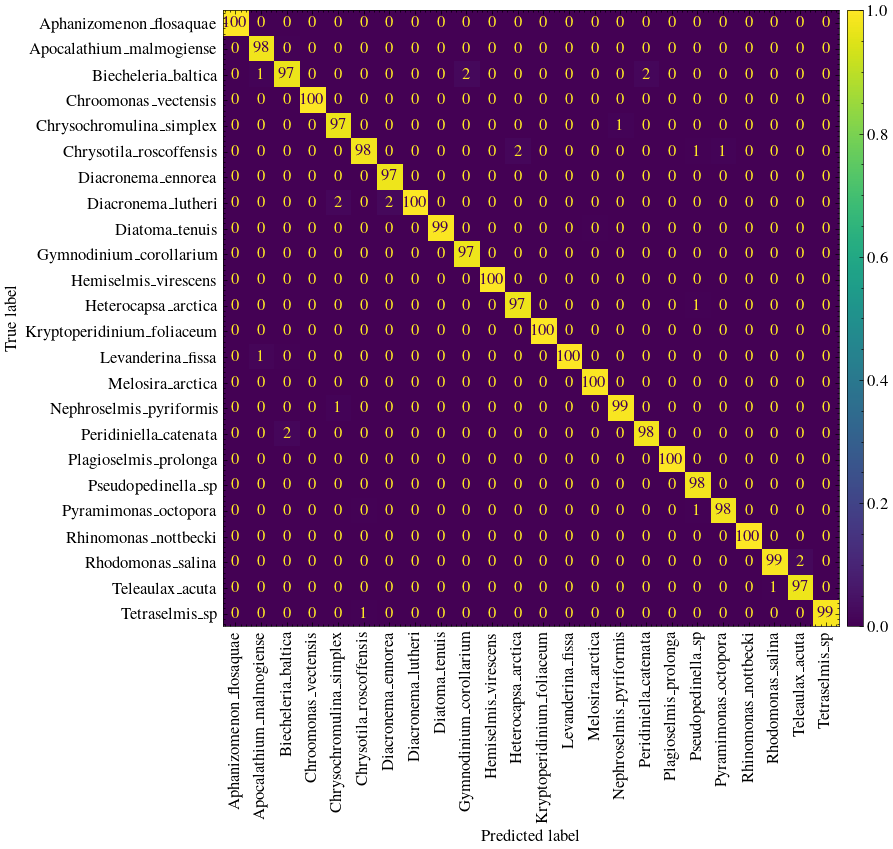

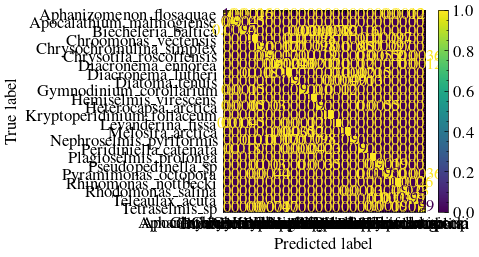

In [12]:
results = data['efficientnet_b0_cnn_2_512_clip_FASTVISION-plus'][3]
reference = embeddings['efficientnet_b0_cnn_2_512_clip_FASTVISION-plus']

pred = np.concatenate(results['pred'])
true = np.concatenate([ref['test']['label'] for ref in reference.values()])


fig, ax = plt.subplots(figsize=(8, 8))
cm = ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=reference[1]['classes'], normalize='pred')

cm.plot(ax=ax, colorbar=False, values_format='.0%')
ax.tick_params(axis='x', labelrotation=90)

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(cm.im_, cax=cax) # Similar to fig.colorbar(im, cax = cax)

fig.savefig('figures/efficientnet_b0_cnn_2_512_clip.pdf')

In [13]:
print(classification_report(true, pred, digits=4, target_names=reference[1]['classes']))


                            precision    recall  f1-score   support

   Aphanizomenon_flosaquae     1.0000    0.9978    0.9989       926
  Apocalathium_malmogiense     0.9780    0.9968    0.9873       936
       Biecheleria_baltica     0.9699    0.9401    0.9548       685
      Chroomonas_vectensis     0.9984    0.9969    0.9977       645
  Chrysochromulina_simplex     0.9709    0.9816    0.9762       543
   Chrysotila_roscoffensis     0.9822    0.9458    0.9637       701
        Diacronema_ennorea     0.9734    0.9865    0.9799       594
        Diacronema_lutheri     0.9976    0.9714    0.9843       839
            Diatoma_tenuis     0.9942    0.9954    0.9948       862
   Gymnodinium_corollarium     0.9737    0.9976    0.9855       818
      Hemiselmis_virescens     0.9971    1.0000    0.9985      1022
       Heterocapsa_arctica     0.9733    0.9894    0.9812       846
Kryptoperidinium_foliaceum     0.9992    1.0000    0.9996      1285
         Levanderina_fissa     0.9977    0.9816

In [19]:
import random
np.random.seed(0)


def sample(y, n):
    idx = []
    orig = np.arange(len(y))
    for label in np.unique(y):
        i = list(orig[y == label])
        j = random.sample(i, n)
        idx.extend(j)
    return np.array(idx)


def test_subset(train, test, n, repeats=10):
    image_train, profile_train, label_train = train
    image_test, profile_test, label_test = test
    accs = []
    for _ in range(repeats):
        idx = sample(label_train, n)
        X = np.concatenate((image_train[idx], profile_train[idx]))
        y = np.tile(label_train[idx], (2,))
        predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)
        pred = predictor.predict(image_test, profile_test, k=3, epsilon=0.2)
        accs.append(accuracy_score(label_test, pred))
    return accs

N = (5, 10, 20, 40, 80, 160, 320,)
results = {name: [] for name in embeddings.keys()}

for name, data in tqdm(embeddings.items()):
    for n in N:
        accs = []
        for fold in range(1, 6):
            train = data[fold]['train'].values()
            test = data[fold]['test'].values()
            accs.append(test_subset(train, test, n))
        results[name].append(np.mean(accs))

100%|██████████| 4/4 [1:47:34<00:00, 1613.63s/it]


In [35]:
data

{1: {'train': {'image': array([[ 1.9422764 ,  0.67604166,  1.0341611 , ..., -1.7674426 ,
           -0.30207634, -0.26617545],
          [ 1.9520857 , -1.6931157 ,  0.57167387, ..., -2.231438  ,
            0.21582454,  0.30931067],
          [ 2.0390737 ,  0.81348836,  0.5442562 , ..., -2.2263572 ,
            0.08496368, -0.5613607 ],
          ...,
          [-0.26447746, -0.14480719, -0.7194569 , ..., -0.08710027,
           -0.7604838 , -0.77846014],
          [-0.53818643,  0.18175131,  1.4299095 , ...,  2.4616854 ,
           -0.9748001 ,  0.2302433 ],
          [ 1.4270838 , -0.9202877 , -0.41960073, ..., -1.4277046 ,
           -0.26806486, -0.85676366]], dtype=float32),
   'profile': array([[ 0.13869175, -0.073226  ,  0.72904974, ..., -0.41942924,
           -0.08838156,  0.54122657],
          [ 0.08548894, -0.26165348,  0.8115199 , ..., -0.26044652,
           -0.02861832,  0.66927934],
          [ 0.11449242, -0.01051477,  0.43095896, ..., -0.59883094,
           -0.002472

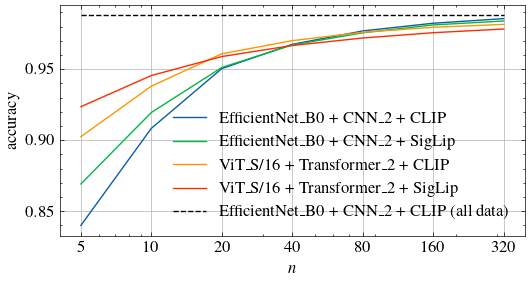

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlabel('$n$')
ax.set_ylabel('accuracy')
ax.set_xscale('log')
ax.set_xticks(N, N)

legends = {
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + CLIP',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus': 'EfficientNet_B0 + CNN_2 + SigLip',
    'vit_s_16_transformer_2_512_clip_FASTVISION-plus': 'ViT_S/16 + Transformer_2 + CLIP',
    'vit_s_16_transformer_2_512_siglip_FASTVISION-plus': 'ViT_S/16 + Transformer_2 + SigLip',
}


for name, accs in results.items():
    ax.plot(N, accs, label=legends[name])

mu = 0.9879
ax.plot((5, 320), (mu, mu), 'k--', label='EfficientNet_B0 + CNN_2 + CLIP (all data)')

ax.legend()
ax.grid()
plt.savefig('figures/subset.pdf')
plt.show()

In [41]:
def benchmark(embs_train, y_train, embs_test, y_test, K=(3, 15, 51, 101)):
    X = np.concatenate(embs_train)
    y = np.tile(y_train, (len(embs_train),))
    predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)
    results = []
    for k in K:
        pred = predictor.predict(*embs_test, k=k, epsilon=0.2)
        acc = accuracy_score(y_test, pred)
        metrics = precision_recall_fscore_support(y_test, pred, average='macro')
        results.append((acc,) + metrics[:-1])
    return results

train_types = ('I', 'P', 'I', 'P')
test_types = ('I', 'P', 'I+P', 'I+P')
results = {name: {fold: [] for fold in range(1, 6)} for name in embeddings.keys()}

for name, data in embeddings.items():
    for fold in tqdm(range(1, 6)):

        image_train = data[fold]['train']['image']
        profile_train = data[fold]['train']['profile']
        label_train = data[fold]['train']['label']

        image_test = data[fold]['test']['image']
        profile_test = data[fold]['test']['profile']
        label_test = data[fold]['test']['label']

        train = (image_train, profile_train, image_train, profile_train)
        test = ((image_test,), (profile_test,), (image_test, profile_test), (image_test, profile_test))

        for train_embs, test_embs in zip(train, test):
            out = benchmark((train_embs,), label_train, test_embs, label_test, K=(3,))[0][0]
            results[name][fold].append(out)

100%|██████████| 5/5 [04:43<00:00, 56.67s/it]


In [43]:
for name, result, in results.items():
    print(name[:-16])
    values = list(result.values())
    for mu, std, train_type, test_type in zip(np.mean(values, 0), np.std(values, 0), train_types, test_types):
        print(f'{train_type:2s}& {test_type:4s}& {mu:.2%}$\\pm${std:.2%} \\\\')

efficientnet_b0_cnn_2_512_clip
I & I   & 96.15%$\pm$0.34% \\
P & P   & 98.15%$\pm$0.25% \\
I & I+P & 97.16%$\pm$0.30% \\
P & I+P & 98.33%$\pm$0.34% \\
efficientnet_b0_cnn_2_512_siglip
I & I   & 95.61%$\pm$0.89% \\
P & P   & 97.82%$\pm$0.42% \\
I & I+P & 96.13%$\pm$0.84% \\
P & I+P & 97.98%$\pm$0.50% \\
vit_s_16_transformer_2_512_clip
I & I   & 96.14%$\pm$0.21% \\
P & P   & 97.08%$\pm$0.27% \\
I & I+P & 96.71%$\pm$0.18% \\
P & I+P & 97.32%$\pm$0.22% \\
vit_s_16_transformer_2_512_siglip
I & I   & 95.23%$\pm$0.73% \\
P & P   & 96.43%$\pm$0.69% \\
I & I+P & 95.91%$\pm$0.67% \\
P & I+P & 96.70%$\pm$0.70% \\


In [ ]:
best = (3, 3, 3, 15)
labels = 
for k, name in zip(best, names):
    true

[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]


In [ ]:
# model = MultiModel.load_from_checkpoint('./logs/efficientnet_b0_cnn_1_unsupervised_128_FASTVISION-plus_fold1/version_0/checkpoints/epoch=80_valid_loss=0.85036.ckpt')
# model = MultiModel.load_from_checkpoint('./logs/CLIP_ef0_cnn1_FASTVISION-plus_fold1/version_9/checkpoints/epoch=67_valid_loss=0.83432.ckpt')
# model = MultiModel.load_from_checkpoint('./logs/CLIP_ef0_cnn2_FASTVISION-plus_fold1/version_2/checkpoints/epoch=82_valid_loss=0.81728.ckpt')
model = MultiModel.load_from_checkpoint(checkpoint)


def multi_collate(batch, model=model):

    image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))

    image = {'image': torch.stack(image)}
    profile = model.profile_encoder.tokenize(profile)
    label = {'label': model.name_to_id(label)}
    image_shape = {'image_shape': torch.stack(image_shape)}
    profile_len = {'profile_len': torch.stack(profile_len)}

    return image | profile | label | image_shape | profile_len

train_loader = DataLoader(dataset=train_set, batch_size=128, 
                          num_workers=8, collate_fn=multi_collate)

test_loader = DataLoader(dataset=test_set, batch_size=128, 
                         num_workers=8, collate_fn=multi_collate)

trainer = Trainer()

train = trainer.predict(model, train_loader)
image_train, profile_train, label_train = zip(*(sample.values() for sample in train))

test = trainer.predict(model, test_loader)
image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
I_train = torch.cat(image_train).numpy()
P_train  = torch.cat(profile_train).numpy()
L_train = torch.cat(label_train).numpy()

I_test = torch.cat(image_test).numpy()
P_test  = torch.cat(profile_test).numpy()
L_test = torch.cat(label_test).numpy()

In [20]:
X = np.concatenate((I_train, P_train))
y = np.tile(L_train, (2,))

predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)

In [27]:
pred = predictor.predict(I_test, P_test, k=9, epsilon=0.2)

(pred == L_test).mean()

np.float64(0.985785536159601)

In [ ]:
index = NNDescent(
    data,
    n_neighbors=64,
    metric='cosine',
    diversify_prob=0.,
    pruning_degree_multiplier=3.
)
index.prepare()

In [17]:
%matplotlib qt

In [10]:
I_e = torch.cat(image_emb).numpy()
P_e = torch.cat(profile_emb).numpy()
# I_e /= np.linalg.norm(I_e, axis=1, keepdims=True)
# P_e /= np.linalg.norm(P_e, axis=1, keepdims=True)
L = torch.cat(label).numpy()

Et = np.concat((I_e, P_e))
Lt = np.tile(L, (2,))

# plt.hist(np.linalg.norm(I_e, axis=1), alpha=0.5)
# plt.hist(np.linalg.norm(P_e, axis=1), alpha=0.5)

mapping = pacmap.PaCMAP(n_components=2, n_neighbors=3, MN_ratio=.5) 
# mapping = TSNE(2)
reduced = mapping.fit_transform(Et)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

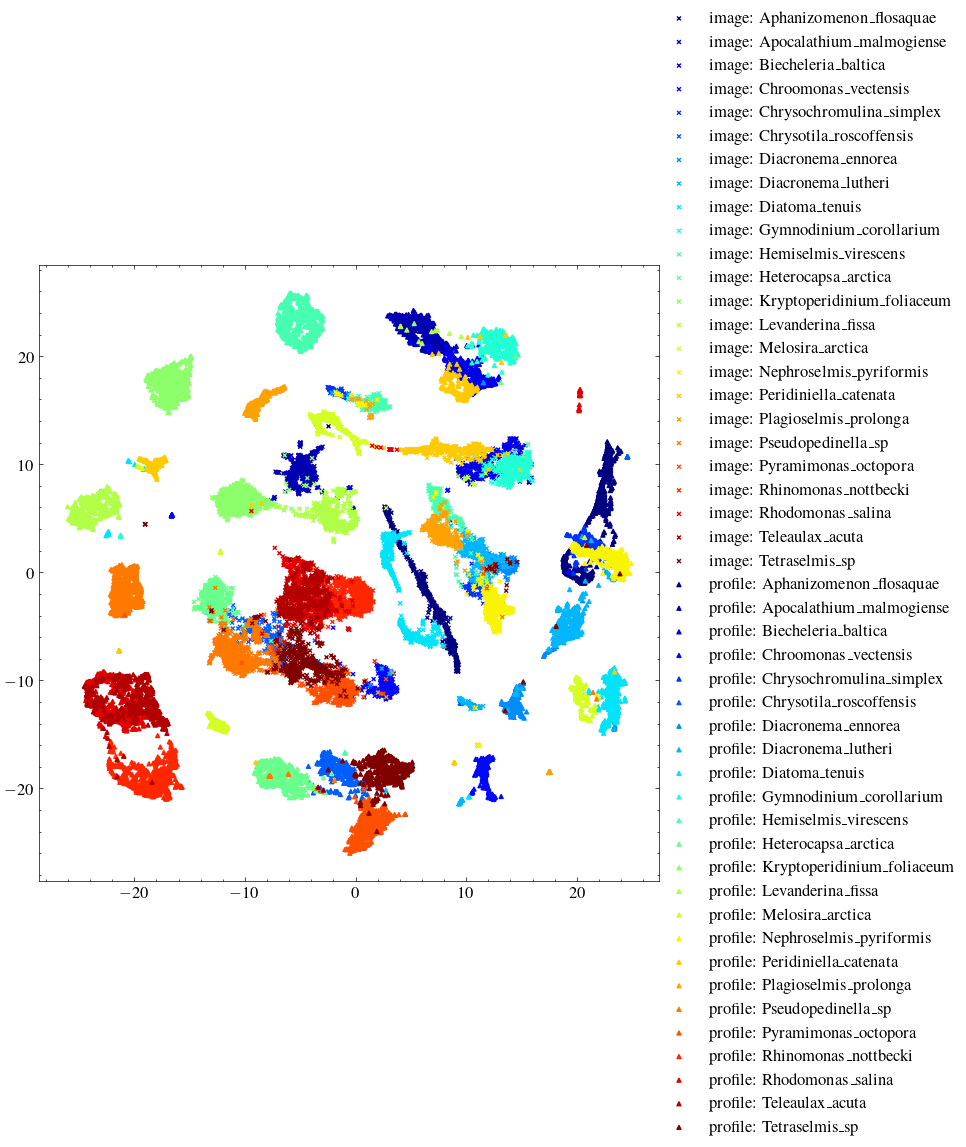

In [12]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

fig = plt.figure()
ax = fig.add_subplot()

cmap = get_cmap(len(model.label_encoder.classes_), 'jet')

n = 22
for y in np.unique(Lt)[:]:
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = reduced[:len(Lt)//2][Lt[:len(Lt)//2] == y]
    ax.scatter(*zip(*e), label=f'image: {class_name}', s=8, c=(cmap(y),)*len(e), marker='x')

for y in np.unique(Lt)[:]:
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = reduced[len(Lt)//2:][Lt[len(Lt)//2:] == y]
    ax.scatter(*zip(*e), label=f'profile: {class_name}', s=8, c=(cmap(y),)*len(e), marker='^')

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=51, metric='cosine').fit(I_e, L)


prob = knn.predict_proba(P_e)

pred = prob.argmax(1)

(pred == L).mean()

np.float64(0.9402416223213002)

In [28]:
print(*model.loss.parameters())

Parameter containing:
tensor(3.0942, requires_grad=True) Parameter containing:
tensor(-10.0596, requires_grad=True)


In [113]:
I_e = torch.cat(image_emb).numpy()
P_e = torch.cat(profile_emb).numpy()
# I_e /= np.linalg.norm(I_e, axis=1, keepdims=True)
# P_e /= np.linalg.norm(P_e, axis=1, keepdims=True)
L = torch.cat(label).numpy()

Et = np.concat((I_e, P_e))
Lt = np.tile(L, (2,))

# Et = I_e.copy()
# Lt = L.copy()

In [114]:
np.linalg.norm(I_e, axis=1).mean(), np.linalg.norm(P_e, axis=1).mean()

(np.float32(5.6273847), np.float32(16.30003))

In [96]:

logits = (I_e / np.linalg.norm(I_e, axis=1, keepdims=True)) @ (P_e / np.linalg.norm(P_e, axis=1, keepdims=True)).T

(L[logits.argmax(1)] == L).mean()

np.float64(0.7950524953257586)

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, metric='cosine').fit(I_e, L)


prob = knn.predict_proba(P_e)

pred = prob.argmax(1)

(pred == L).mean()

np.float64(0.8586221774773479)

In [ ]:
from sklearn.metrics import top_k_accuracy_score

print(*map(float, [top_k_accuracy_score(L, prob, k=k) for k in range(1, 6)]))

[np.float64(0.862073924924493), np.float64(0.9376528117359413), np.float64(0.9513159787142241), np.float64(0.9565655112900906), np.float64(0.957356536746728)]


In [99]:
reduced = TSNE(2, perplexity=10, early_exaggeration=20).fit_transform(Et)

In [61]:
list(map(float, cmap(1)))

[0.0, 0.0, 0.6976284584980237, 1.0]

In [39]:
%matplotlib qt

In [116]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = get_cmap(len(model.label_encoder.classes_), 'jet')

for y in np.unique(Lt):
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = Et[:len(Lt)//2][Lt[:len(Lt)//2] == y]
    ax.scatter(*zip(*e), label=f'image: {class_name}', s=4, c=(cmap(y),)*len(e), marker='x')

for y in np.unique(Lt):
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = Et[len(Lt)//2:][Lt[len(Lt)//2:] == y]
    ax.scatter(*zip(*e), label=f'profile: {class_name}', s=4, c=(cmap(y),)*len(e), marker='^')

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()